In [1]:
import sys
sys.path.append('../src/')
del sys

In [2]:
import math

import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib as mpl

import event2vec.models as models
import event2vec.losses as losses
import event2vec.utils as utils

from event2vec.datasets import VBFHDataset
from event2vec.util import tril_to_matrix

import treescope
treescope.basic_interactive_setup()

In [3]:
import dataclasses
from typing import Callable
import optax
from rich.progress import TextColumn
from event2vec.util import standard_pbar

@dataclasses.dataclass
class TrainingConfig:
    """Configuration for the training process."""

    test_fraction: float
    """Fraction of the dataset to use for testing."""
    batch_size: int
    """Batch size for training."""
    learning_rate: float
    """Learning rate for the optimizer."""
    epochs: int
    """Number of epochs to train for."""
    loss_fn: Callable
    """Loss function to use for training."""

def train(
    config: TrainingConfig,
    *,
    model, data, key):
    
    key, subkey = jax.random.split(key)
    data_train, data_test = data.split(config.test_fraction, key=subkey)
    diff_model, static_model = utils.partition_trainable_and_static(model)
    
    @eqx.filter_jit
    def make_step(
        diff_model, batch,
        opt_state: optax.OptState,
        *,
        key: jax.Array):
        
        @eqx.filter_value_and_grad
        def loss_grad(diff_model, batch, *, key):
            model = eqx.combine(diff_model, static_model)
            return config.loss_fn(model, batch, key=key)

        loss, grads = loss_grad(diff_model, batch, key=key)
        updates, opt_state = optim.update(grads, opt_state, diff_model)
        diff_model = eqx.apply_updates(diff_model, updates)
        return loss, diff_model, opt_state

    optim = optax.adamw(config.learning_rate, b1=0.9)
    opt_state = optim.init(diff_model)

    train_loss_history: list[float] = []
    test_loss_history: list[float] = []
    pbar = standard_pbar(TextColumn("Test loss: {task.fields[loss]:.4f}"))
    with pbar as progress:
        epoch_task = progress.add_task("Training...", total=config.epochs, loss=0.0)
        for _ in range(config.epochs):
            tmp = []
            for i, batch in enumerate(data_train.iter_batch(config.batch_size)):
                key, subkey = jax.random.split(key)
                loss, diff_model, opt_state = make_step(
                    diff_model, batch, opt_state, key=subkey
                )
                tmp.append(loss.item())
            train_loss_history.append(sum(tmp) / len(tmp))
            key, subkey = jax.random.split(key)
            model = eqx.combine(diff_model, static_model)
            test_loss = eqx.filter_jit(config.loss_fn)(
                model, data_test, key=subkey
            ).item()
            test_loss_history.append(test_loss)
            progress.update(epoch_task, advance=1, loss=test_loss)

    return model, train_loss_history, test_loss_history

In [4]:
data = VBFHDataset.from_lhe("../data/smeftsim_VBFH-*.lhe.gz")

Output()

LHE weight fit residuals mean: 1.2227341535109293e-12 std: 7.60633092969365e-13


/home/prasanth/prasanth@WSL/Research/event2vec_4_EFT/github_repo/event2vec/notebook/../src/event2vec/datasets/lhedataset.py:247: UserWarning: Coefficient matrix is not positive semi-definite, negative eigenvalues: [-6.8273484e-06]
  latent_norm = QuadraticFormNormalization.from_coefficients(


In [5]:
input_shape = data.observables.shape[1:]
latent_shape = data.latent_data.shape[1:]

input_dim = math.prod(input_shape)

assert len(latent_shape) == 1
param_dim = int((jnp.sqrt(8 * latent_shape[0] + 1) - 1) / 2)

print(f"{input_shape = }\n{param_dim = }")

input_shape = (13,)
param_dim = 6


In [6]:
model_init_key = jax.random.key(1)
training_key = jax.random.key(2)

D_model_init_key, A_model_init_key = jax.random.split(model_init_key, 2)
D_training_key, A_training_key = jax.random.split(training_key, 2)

In [7]:
avg_latent_matrix = tril_to_matrix(data.latent_data).mean(axis=0)

eigvals, eigvectors = jnp.linalg.eigh(avg_latent_matrix)

In [8]:
U_model = utils.ArrayAsNonTrainableModel(eigvectors)

In [9]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim,),
    'hidden_widths': [16, 32, 32, 16],
    'hidden_activation': jax.nn.relu,
    'final_activation': jnp.exp,
    'use_hidden_bias': True,
    'use_final_bias': True
}

D_model = models.MLP(**mlp_config, key=D_model_init_key)

In [10]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim, param_dim),
    'hidden_widths': [64, 128, 128, 128, 64],
    'hidden_activation': jax.nn.relu,
    'final_activation': jax.nn.identity,
    'use_hidden_bias': True,
    'use_final_bias': True
}

A_model = models.MLP(**mlp_config, key=A_model_init_key)

In [11]:
psd_matrix_model = models.psd_matrix_models.U_sqrtD_At_A_sqrtD_Ut_Model(
    N = param_dim,
    U_model=U_model,
    D_model=D_model,
    A_model=A_model,
    normalize_A_cols=True
)

## Training only the D model

In [12]:
loss = losses.psd_matrix_losses.DiagMSELoss()

utils.set_nontrainable(psd_matrix_model.A_model)

In [ ]:
models.

In [13]:
untrained_psd_matrix_model = psd_matrix_model

In [14]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=128,
    learning_rate=0.001,
    epochs=100,
    loss_fn=loss
)

In [15]:
intermediate_psd_matrix_model, train_loss_history, test_loss_history = train(config=training_config, model=untrained_psd_matrix_model, data=data, key=D_training_key)

Output()

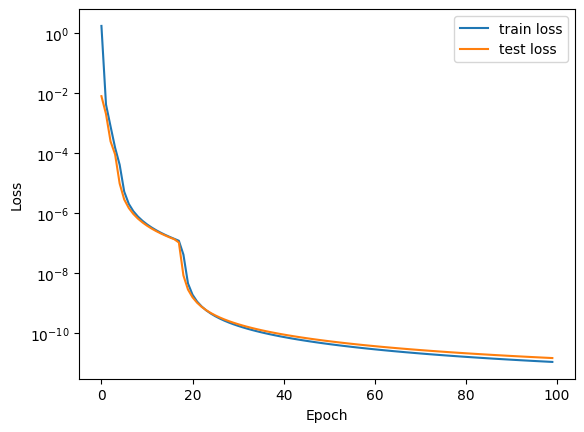

In [16]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
ax.set_yscale('log')
ax.legend()

In [17]:
utils.is_nontrainable(intermediate_psd_matrix_model.A_model)

True

## Training only the A model

In [18]:
utils.unset_nontrainable(intermediate_psd_matrix_model.A_model)
utils.set_nontrainable(intermediate_psd_matrix_model.D_model)

In [19]:
param_mean = jnp.zeros(param_dim).at[0].set(1)
param_cov = (jnp.eye(param_dim).at[0,0].set(0)) * 0.1

loss = losses.psd_matrix_losses.HyperQuadNormLoss(
    P_tensor=utils.mvn_fourth_moment(
        mean=param_mean,
        cov=param_cov,
        is_central=False
    )
)

In [37]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=128,
    learning_rate=0.001,
    epochs=100,
    loss_fn=loss
)

In [38]:
trained_psd_matrix_model, train_loss_history, test_loss_history = train(config=training_config, model=intermediate_psd_matrix_model, data=data, key=A_training_key)

Output()

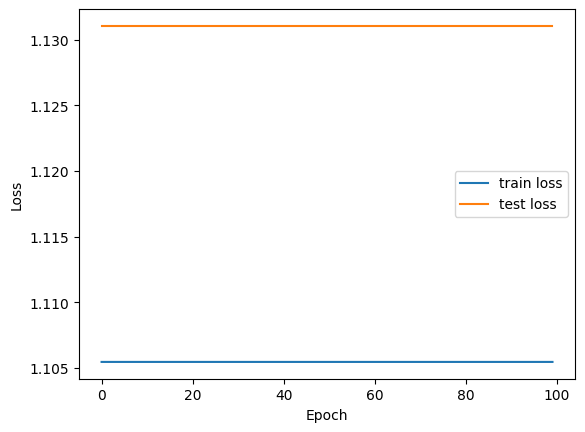

In [39]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
ax.legend()

In [42]:
utils.is_nontrainable(trained_psd_matrix_model.U_model)

True

In [24]:
latent_matrix = tril_to_matrix(data.latent_data)

In [25]:
pred_matrix_before_training = jax.vmap(untrained_psd_matrix_model)(data.observables)
pred_matrix = jax.vmap(trained_psd_matrix_model)(data.observables)

In [26]:
latent_lengths = []
pred_lengths = []
pred_lengths_before_training = []

for i in range(6):
    latent_lengths.append(jnp.sum(jnp.sum(latent_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths.append(jnp.sum(jnp.sum(pred_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths_before_training.append(jnp.sum(jnp.sum(pred_matrix_before_training * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))

latent_lengths = jnp.array(latent_lengths)
pred_lengths = jnp.array(pred_lengths)
pred_lengths_before_training = jnp.array(pred_lengths_before_training)

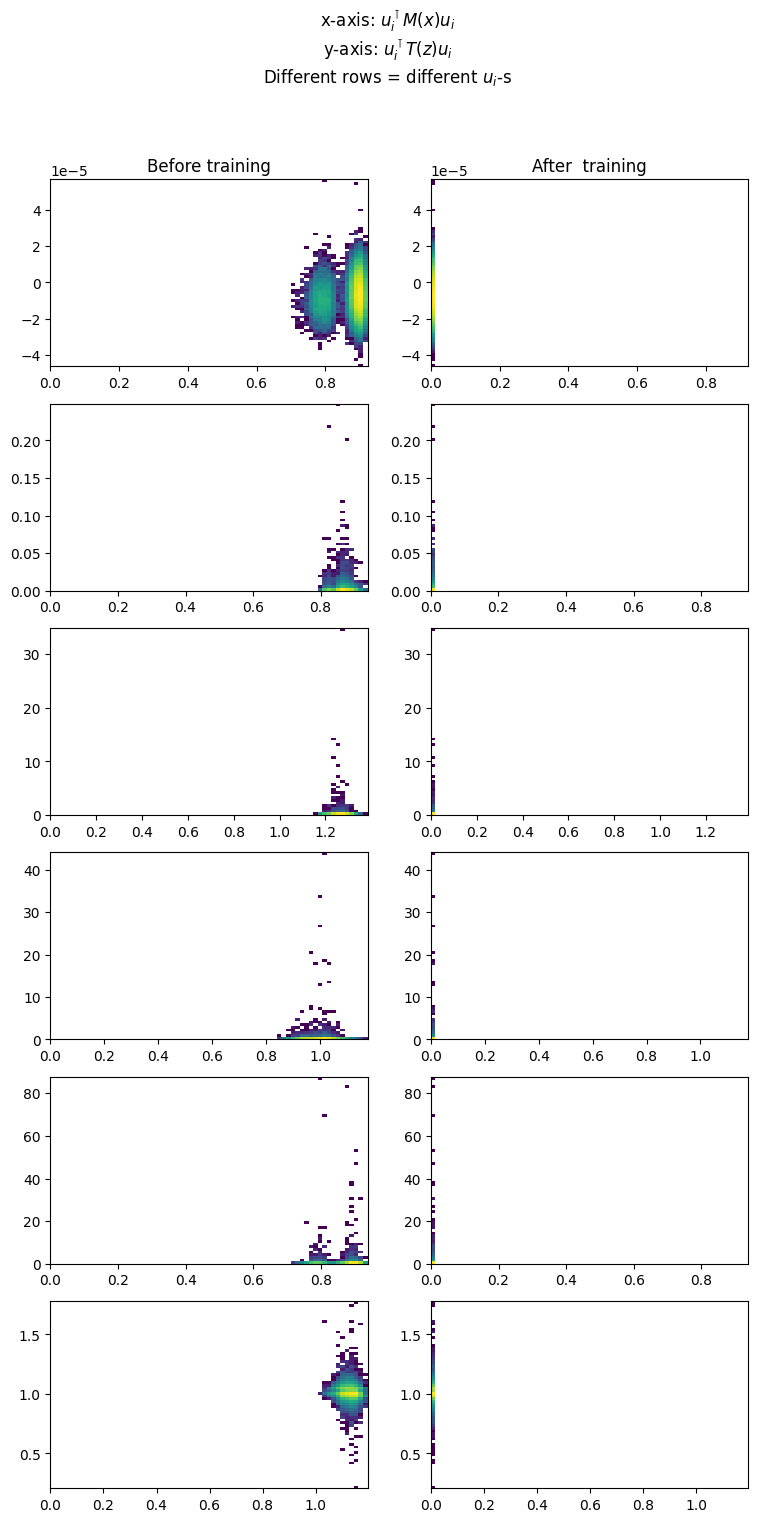

In [27]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(pred_lengths[i]), jnp.min(pred_lengths_before_training[i]))
    x_hi = max(jnp.max(pred_lengths[i]), jnp.max(pred_lengths_before_training[i]))

    y_lo = jnp.min(latent_lengths[i])
    y_hi = jnp.max(latent_lengths[i])
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(pred_lengths_before_training[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(pred_lengths[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $u_i^\\intercal M(x) u_i$ \ny-axis: $u_i^\\intercal T(z) u_i$\nDifferent rows = different $u_i$-s")

None

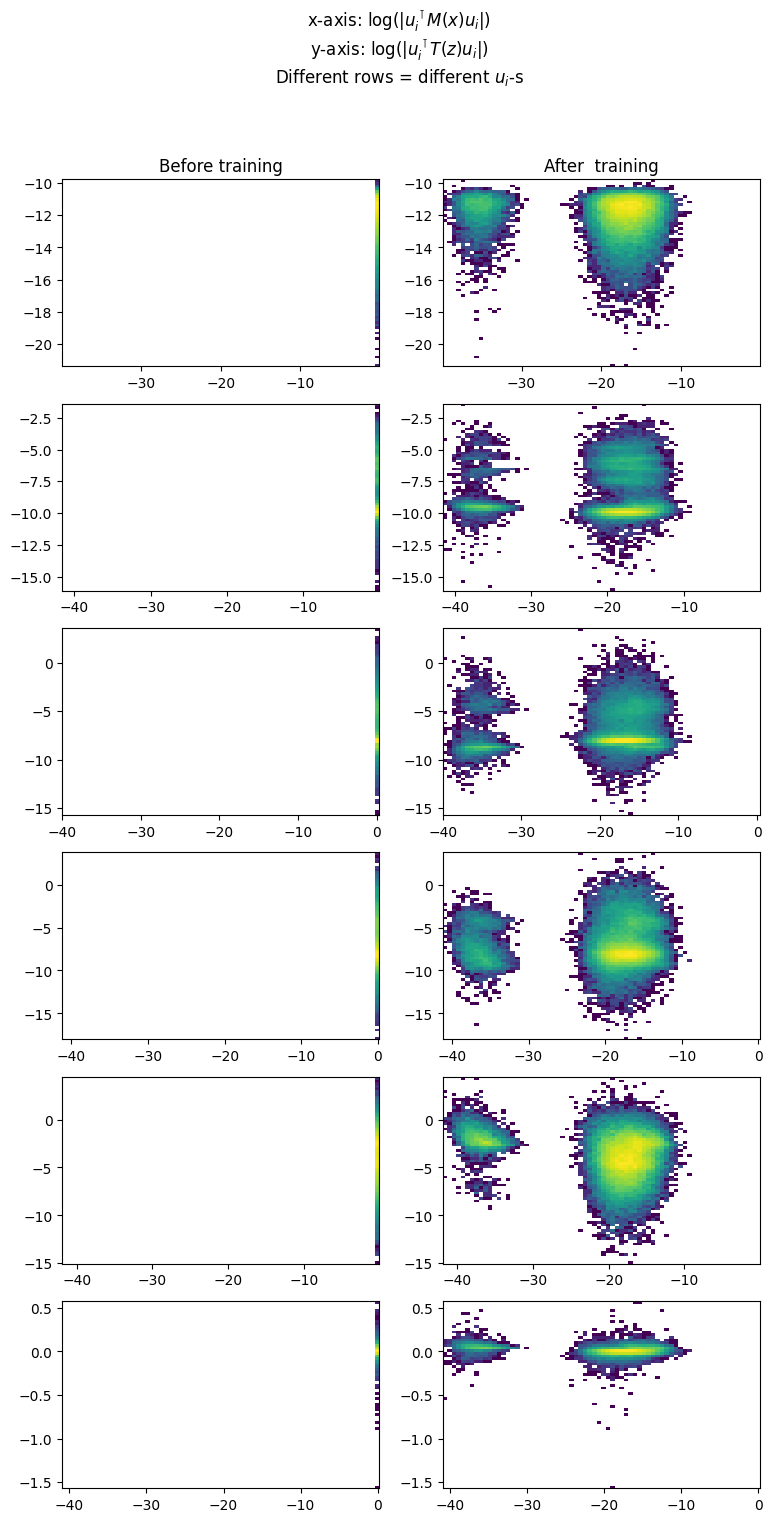

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(jnp.log(jnp.abs(pred_lengths[i]))), jnp.min(jnp.log(jnp.abs(pred_lengths_before_training[i]))))
    x_hi = max(jnp.max(jnp.log(jnp.abs(pred_lengths[i]))), jnp.max(jnp.log(jnp.abs(pred_lengths_before_training[i]))))

    y_lo = jnp.min(jnp.log(jnp.abs(latent_lengths[i])))
    y_hi = jnp.max(jnp.log(jnp.abs(latent_lengths[i])))
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(jnp.log(jnp.abs(pred_lengths_before_training[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(jnp.log(jnp.abs(pred_lengths[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $\\log(|u_i^\\intercal M(x) u_i|)$ \ny-axis: $\\log(|u_i^\\intercal T(z) u_i|)$\nDifferent rows = different $u_i$-s")

None

In [29]:
avg_pred_matrix_before_training = pred_matrix_before_training.mean(axis=0)
avg_pred_matrix = pred_matrix.mean(axis=0)

In [30]:
jnp.linalg.eig(avg_latent_matrix - avg_pred_matrix_before_training)

EigResult(eigenvalues=Array([ 0.39506376+0.j, -1.8317444 +0.j, -0.3579212 +0.j, -0.727351  +0.j,
       -1.0749257 +0.j, -1.2679011 +0.j], dtype=complex64), eigenvectors=Array([[ 0.81570154+0.j,  0.06981979+0.j, -0.12357816+0.j,
         0.24088724+0.j,  0.5058749 +0.j, -0.02342199+0.j],
       [ 0.20649303+0.j, -0.4356176 +0.j, -0.3136367 +0.j,
        -0.8050771 +0.j,  0.02730343+0.j, -0.14260232+0.j],
       [ 0.2628846 +0.j,  0.5402533 +0.j,  0.63220036+0.j,
        -0.4534882 +0.j, -0.13388827+0.j, -0.125552  +0.j],
       [-0.46046102+0.j,  0.17561202+0.j,  0.03463393+0.j,
        -0.13409959+0.j,  0.77322364+0.j, -0.3742717 +0.j],
       [-0.06400882+0.j,  0.6710411 +0.j, -0.6277459 +0.j,
        -0.19544119+0.j, -0.03418172+0.j,  0.334927  +0.j],
       [-0.08223009+0.j, -0.17986985+0.j,  0.30235514+0.j,
        -0.17886534+0.j,  0.35549384+0.j,  0.84326583+0.j]],      dtype=complex64))

In [31]:
jnp.linalg.eig(avg_latent_matrix - avg_pred_matrix)

EigResult(eigenvalues=Array([ 1.0072080e+00+0.j,  1.2553568e-01+0.j,  2.4446160e-02+0.j,
        1.1366775e-02+0.j, -7.2572570e-06+0.j,  9.8455627e-04+0.j],      dtype=complex64), eigenvectors=Array([[ 9.9619883e-01+0.j,  5.8231860e-02+0.j, -1.4336565e-02+0.j,
         1.6420737e-02+0.j,  6.0481381e-02+0.j,  7.9779280e-03+0.j],
       [ 6.0394406e-02+0.j,  3.6090650e-03+0.j, -7.8404805e-04+0.j,
         1.7816123e-03+0.j, -9.9814945e-01+0.j, -5.7701604e-03+0.j],
       [-5.0893193e-03+0.j,  2.1956074e-03+0.j,  5.9363332e-02+0.j,
        -1.0630699e-01+0.j, -6.2768734e-03+0.j,  9.9252439e-01+0.j],
       [ 5.9497710e-02+0.j, -9.9541348e-01+0.j,  7.3620051e-02+0.j,
        -1.3455499e-02+0.j, -6.1974599e-05+0.j, -3.3377116e-03+0.j],
       [ 3.2397623e-03+0.j, -4.5569852e-02+0.j, -7.4211532e-01+0.j,
        -6.6816539e-01+0.j, -4.2213537e-04+0.j, -2.7064623e-02+0.j],
       [ 1.9076541e-02+0.j,  6.0552772e-02+0.j,  6.6341156e-01+0.j,
        -7.3607069e-01+0.j,  2.2382310e-04+0.j, -1.1855262e-01+0.j]],      dtype=complex64))

In [32]:
alt_param = jnp.ones(param_dim).at[1:].set(
    jax.random.multivariate_normal(key=jax.random.key(0), mean=param_mean[1:], cov=param_cov[1:,1:])
)
print(alt_param)

[ 1.          0.5131245   0.64044493 -0.1371146  -0.02486099  0.05568483]


In [33]:
true_alt_reweights = jnp.sum(latent_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))
pred_alt_reweights = jnp.sum(pred_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))

alt_param.tolist() = [1.0, 0.5131245255470276, 0.6404449343681335, -0.13711459934711456, -0.024860989302396774, 0.055684830993413925]


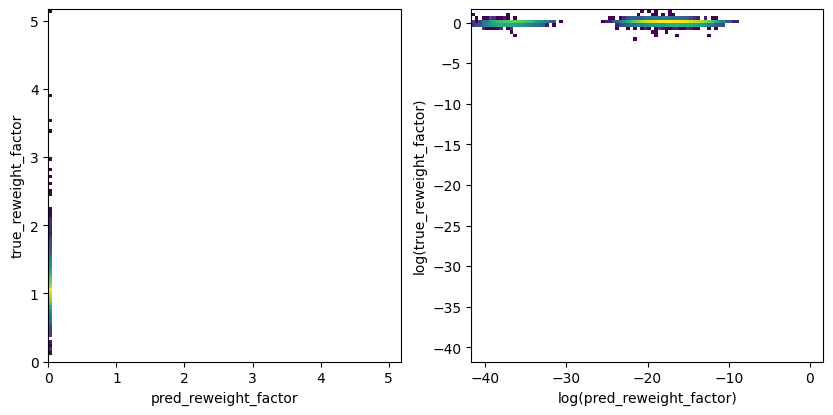

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

lo = min(jnp.min(pred_alt_reweights), jnp.min(true_alt_reweights))
hi = max(jnp.max(pred_alt_reweights), jnp.max(true_alt_reweights))

axes[0].hist2d(pred_alt_reweights, true_alt_reweights, range=((lo, hi), (lo, hi)), bins=100, norm=mpl.colors.LogNorm())
axes[1].hist2d(jnp.log(pred_alt_reweights), jnp.log(true_alt_reweights), range=jnp.log(jnp.array(((lo, hi), (lo, hi)))), bins=100, norm=mpl.colors.LogNorm())

for ax in axes:
    ax.set_aspect('equal')

axes[0].set_xlabel('pred_reweight_factor')
axes[0].set_ylabel('true_reweight_factor')

axes[1].set_xlabel('log(pred_reweight_factor)')
axes[1].set_ylabel('log(true_reweight_factor)')

print(f"{alt_param.tolist() = }")

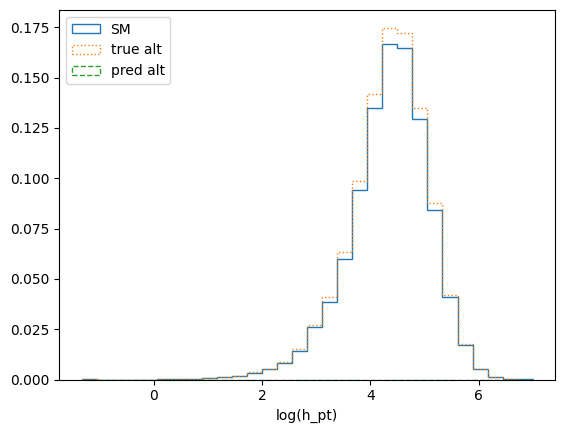

In [35]:
fig, ax = plt.subplots()

log_h_pt = data.observables[:,0]

bins=30
num_events = len(data.observables)

ax.hist(log_h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("log(h_pt)")

ax.legend(loc=2)

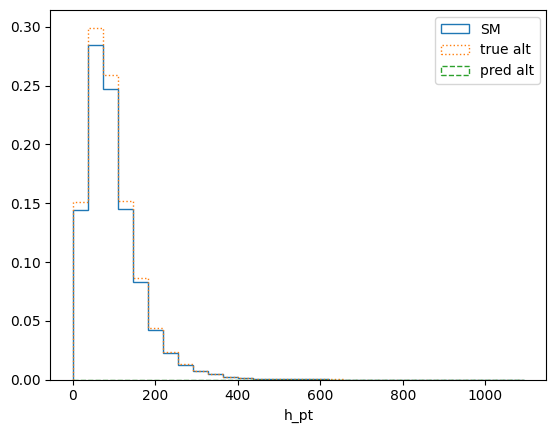

In [36]:
fig, ax = plt.subplots()

h_pt = jnp.exp(data.observables[:,0])

bins=30
num_events = len(data.observables)

ax.hist(h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("h_pt")

ax.legend(loc=1)

In [43]:
pred_alt_reweights

Array([7.7437576e-09, 3.8630806e-16, 7.0328483e-08, ..., 4.3660727e-08,
       5.7629718e-10, 1.9795883e-17], dtype=float32)